(chap:astrometry)=
# Astrometric Corrections

Because we are combining the data from two different instruments, there are corrections that must be made to the coordinates of the X-ray sources such that it is propely in line with the coordinate system of *HST*. There will be some intrinsic amount of uncertainty in the XRBs' coordinates due to the differences in the X-ray and optical resolution of their respective instruments. These are accounted for by defining 1- and 2-$\sigma$ regions around each XRB, which trace out the regions within which we are 68% and 95% sure that the source falls. These regions are calculated using the information obtained through the astrometric correction process --- namely, the standard deviation of the median offset between optical and X-ray coordinates. This Chapter outlines how to conduct an astrometric correction and calculate the 1- and 2-$\sigma$ positional uncertainty regions around each XRB. 

## Calibrator Selection
To calibrate between X-ray and optical source coordinates, we need to select a sample of optical sources that we are reasonably certain are producing the X-ray emissions we detect. These include background galaxies (AGN and quasars), foreground stars, and isolated globular clusters (for example, {numref}`fig-astrometric-calibrators`). To find these sources, we must plot the coordinates of each X-ray source onto the *HST* image. We then identify the X-ray sources and their optical counterparts that are best suited for the assessment. You will want to pull the coordinates for each selected X-ray source, and (if you choose to do a by-hand correction) their associated optical source. 

```{figure} astrometric_calibrators.png
:name: fig-astrometric-calibrators
:width: 750px

Examples of X-ray sources that can be used as calibrators for the astrometric correction. The first 3 images are of AGN and quasars, based on their shapes and/or extremely red colors. The 4th is a foreground star, identifiable by the diffraction spikes. The last is a (somewhat) isolated globular cluster, based on the shape, color, and size relative to typical stars in M101.
```

## Correction Calculation and Application
As you may have guessed, I've written a function that will calculate the astrometric corrections automatically, called `CorrectAstrometry` (Chapter \ref{sec:script-correctastrometry}). It takes in the coordinates of your selected X-ray sources (`cat_coords`) and finds the nearest optical source from the coordinates of some base catalog (`base_coords`, which in this case are the coordinates from the `DAOStarFinder` catalog[^1]). Alternatively, you can calculate the astrometric correction yourself by hand-selecting the best optical source position of each calibrator and finding the median x- and y-coordinate offset between the optical and X-ray positions, as well as the standard deviation of those offsets. 

If the standard deviations on the offsets are larger than the median offsets, then that suggests the *CXO* sources are already well-aligned with the *HST* image and no coordinate shift is necessary. The standard deviations on those shifts, however, are still needed to calculate the positional uncertainties, as it represents the variations in where the optical counterparts fall with respect to the X-ray coordinates of the selected sources. Ideally these will be small, but they're expected to be non-zero. 

Below is the code I use to find the X-ray calibrators and call `CorrectAstrometry` to calculate the correction: 

Reading in sources from M101_CSC.frame...
Saving M101_cscsources.reg
9 calibrators to match...
9 calibrators found.
Saving M101_calibrators.reg
Retrieving coordinates from M101_daofind_f555w_acs_fk5.reg


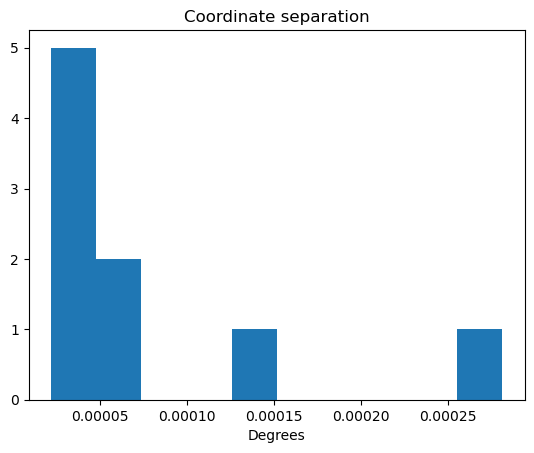

Median separation: 3.6742641485463844e-05
Input min and max separation:0,0.0004


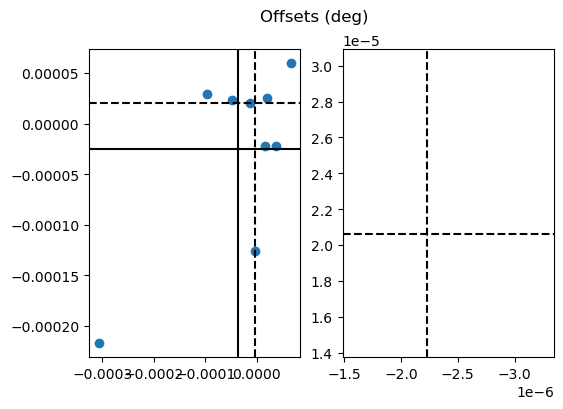

Median offsets in x and y -2.230298662198038e-06 2.061739571246335e-05


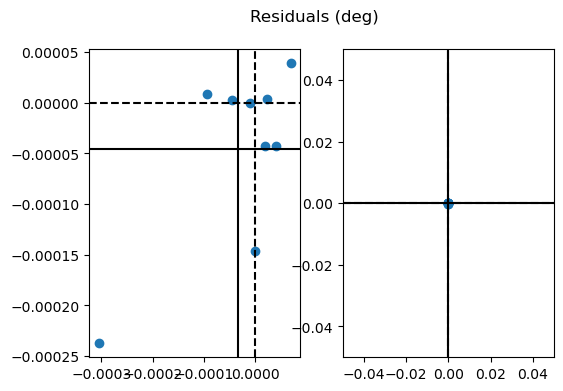


RESULTS OF ASTROMETRY CORRECTION
Median offsets in x and y:
 -2.230298662198038e-06 2.061739571246335e-05 degrees
 -0.008029075183912937 0.07422262456486806 arcsecs
Standard deviation in x and y offsets:
 0.0001059225655179264 8.435623829854083e-05 degrees
 0.38132123586453504 0.30368245787474696 arcsecs

Saving M101_astrocorrect.reg
Check region file for correct assessments.


(-2.230298662198038e-06,
 2.061739571246335e-05,
 0.0001059225655179264,
 8.435623829854083e-05)

In [5]:
from Sources import LoadSources, GetCoords
%run Sources.py
from WriteScript import WriteReg
%run WriteScript.py
from DataFrameMod import RemoveElse, FindUnique
%run DataFrameMod.py
from Align import CorrectAstrometry
%run Align.py

# Reading in sources from the DataFrame containing all of the X-ray sources
# You can use pd.read_csv() instead of LoadSources, if you prefer
M101_CSC = LoadSources("cscresults_M101.frame")

# Find X-ray sources with a unique CSC ID,
# in case multiple rows in the the DataFrame have the same CSC ID
M101_unique = FindUnique(M101_CSC, header="CSC ID")

# Saving M101 to a region file that can be opened in DS9
WriteReg(M101_unique, outfile="M101_cscsources.reg", idname="CSC ID", radius=50, width=2, 
         color="hotpink", showlabel=True)

The code above reads in the region file containing the X-ray sources (created in {ref}`sec:csc-dataframe`) and saves a region file of these sources called `M101_cscsources.reg`. Open whatever image you want to align these sources to in `DS9` (I use the F555W mosaic file created in {ref}`sec:astrodrizzle`) with `Region > Open`. Then, inspect the image to select a handful of good astrometric calibrator sources (see {numref}`fig-astrometric-calibrators`). 

In [ ]:
# List of source names to use as calibrators in the Astrometric Correction
# These I identified manually by inspecting the HST image in DS9 with the 
# regions saved above plotted over the image
M101_calibrators = ['2CXO J140251.0+542420', 
                    '2CXO J140248.0+542403', 
                    '2CXO J140356.0+542057',
                    '2CXO J140355.8+542058',
                    '2CXO J140357.6+541856',
                    '2CXO J140339.3+541827',
                    '2CXO J140346.1+541615',
                    '2CXO J140253.3+541855',
                    '2CXO J140252.1+541946']

print(len(M101_calibrators), "calibrators to match...")

# Using DataFrameMod.RemoveElse() to remove all but the sources above from the DataFrame
M101_calibrators = RemoveElse(M101_unique, keep=M101_calibrators, header="CSC ID")
print(len(M101_calibrators), "calibrators found.")

# Saving these as a region file, in case we want to double-check
WriteReg(M101_calibrators, outfile="M101_calibrators", radius=25, width=2)

The catalog coordinates you'll want to use are the coordiates of the calibrators, while the base coordinates you're aligning them to come from the source extraction conducted in {ref}`sec:runphots`. Make sure you're using the same coordinate system for both lists (in my case, I'm using the galaxy coordiates, which are designated `fk5` in `DS9`. Thus, I pull the base coordinates from `M101_daofind_f555w_acs_fk5.reg`). 

In [ ]:
# Setting up the base and the catalog coordinates for CorrectAstrometry
base_coords = GetCoords("M101_daofind_f555w_acs_fk5.reg")
cat_coords = [M101_calibrators["RA"].values.tolist(), M101_calibrators["Dec"].values.tolist()]

# Running CorrectAstrometry
CorrectAstrometry(base_coords, cat_coords, returnshifts=True, savebasereg="M101_astrocorrect.reg")

Here we see that the median x and y shifts are smaller than their standard deviation. This means the alignment is already pretty good, and that we just need to use the standard deviations to calculate the positional uncertainty radii! Otherwise, you will want to take the median shifts and apply this astrometric correction to the coordinates of your X-ray catalog. *`CorrectAstrometry` will not do this for you!*

(sec:calcPU)=
## Calculating Positional Uncertainty

Because of different instrumental resolutions and inherent uncertainties, it isn't possible to know the *exact* location of an X-ray source on the *HST* optical image, but the positional uncertainty defines a region within which we are reasonably certain the X-ray source falls. This is defined by 1- and 2-$\sigma$ radii, representing the region within which the source has a 608% and 95% chance of being found. 

There are two components that go in to the positional uncertainty estimation: the X-ray positional uncertainty, and the standard deviation on the astrometric correction above. The X-ray positional uncertainty is due to the fact that the PSF of *CXO* increasingly degrades for sources that are an increasing distance from the telescope's main pointing at the time of the observation. That is, the farther the X-ray source is from the center of the image, the harder it is to tell where those detected X-rays came from. 

The X-ray positional uncertainty is obtained using formulas from {cite:p}`kim2007`:
#### INSERT IMAGE OF THESE FORMULAS

The source counts and the off-axis angle are `src_cnts_aper_b` and `theta` or `theta_mean` from {ref}`chap:csc-data`, which I renamed `Counts` and `Theta` in my `DataFrame`. 

The positional uncertainties from the standard deviations are added in quadrature to the X-ray uncertainties, meaning you sum the squares and take the square root. So for the 

All of these steps are handled by `Align.CalcPU()`: 

In [ ]:
from Align import CalcUP
%run Align.py

# Takes in DataFrame or Off-axis Angle/Counts and returns 1 and 2sig
# NOTE: theta needs to be in arcminutes, which is the default CSC unit
sig1, sig2 = CalcPU(M101_CSC, std=[0.3813,0.3037])
print(sig1, sig2)

#### CHECK MY PU CALCULATION FOR M81

This can be saved directly into to your `DataFrame`: 

In [ ]:
M101_CSC['1Sig'] = sig1
M101_CSC['2Sig'] = sig2

SaveDF(M101_CSC, 'M101_cscsources.frame')

# Saving the 1 and 2 sigma region files for DS9 use.
### UPDATE THIS ###
WriteReg(M101_CSC, 'M101_cscsources_1sig.reg')
WriteReg(M101_CSC, 'M101_cscsources_2sig.reg')